In [110]:
import torch
from torchvision import datasets, transforms
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

In [111]:


data_dir1 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'
data_dir2 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'
data_dir3 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'



In [112]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Пример размера
    transforms.ToTensor(),
])

In [113]:
dataset1 = datasets.ImageFolder(root=data_dir1)
dataset2 = datasets.ImageFolder(root=data_dir2)
dataset3 = datasets.ImageFolder(root=data_dir3)

In [114]:
dataset1.classes

['all', 'hem']

In [115]:
combined_dataset = ConcatDataset([dataset1, dataset2, dataset3])

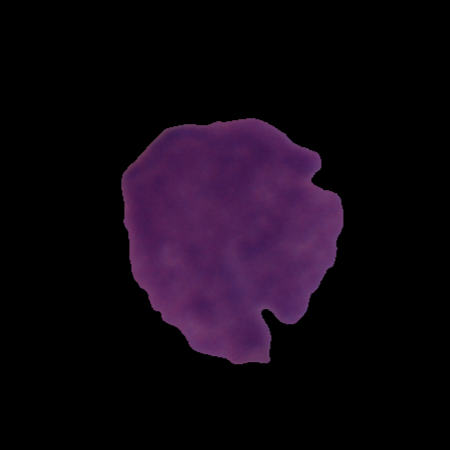

In [116]:
image_tensor, label = combined_dataset[0]
image_tensor

In [117]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розрахунок розмірів для тренувального та валідаційного наборів
train_size = int(train_ratio * len(combined_dataset))
val_size = len(combined_dataset) - train_size

# Розділення набору даних на тренувальний та валідаційний
train_data, val_data = random_split(combined_dataset, [train_size, val_size])

In [118]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.CenterCrop((200, 200)),
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [119]:
len(train_data), len(val_data)

(8528, 2133)

In [120]:
batch_size = 256

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

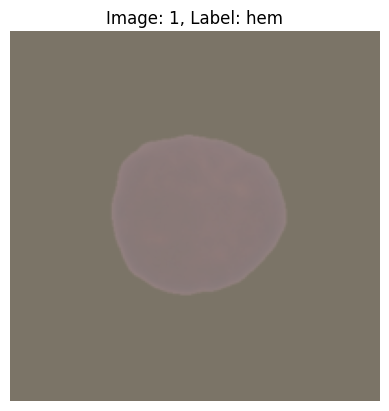

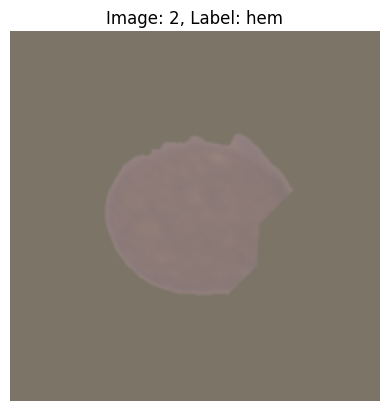

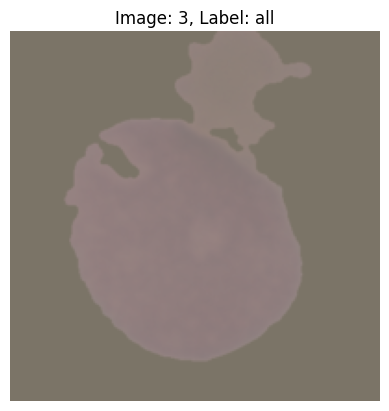

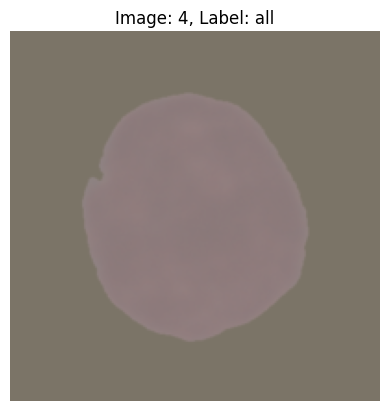

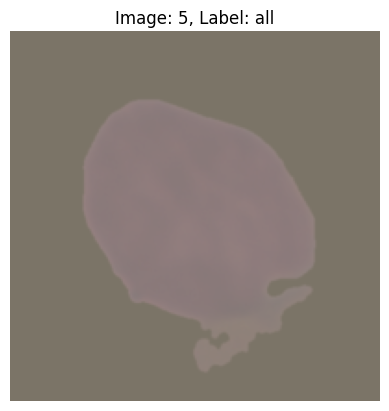

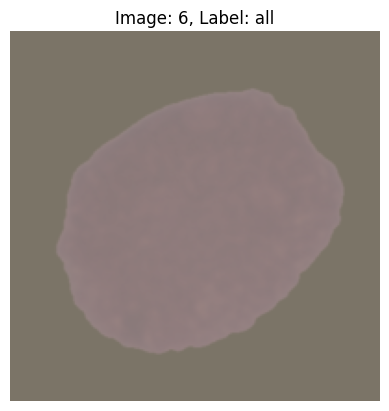

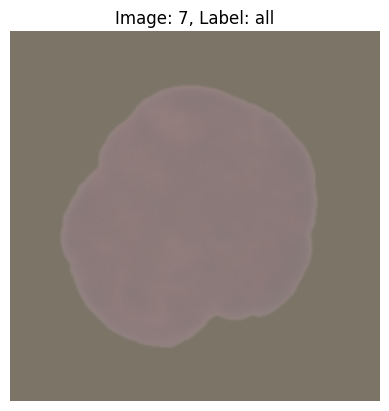

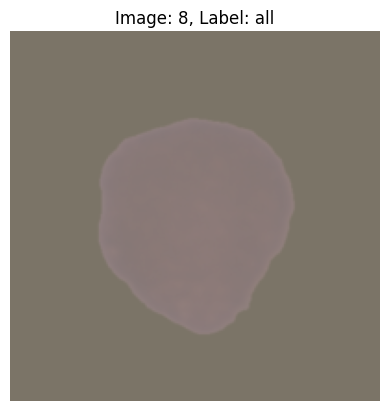

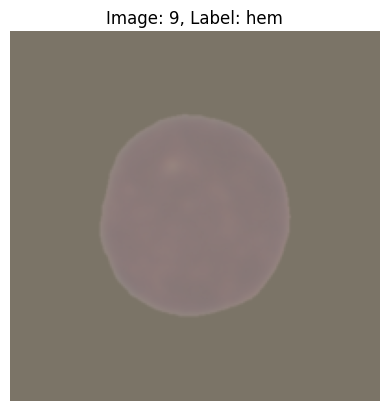

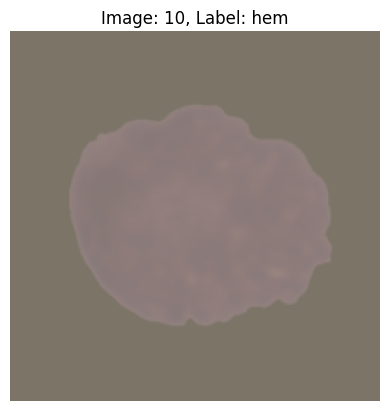

In [121]:
import matplotlib.pyplot as plt

# Якщо ви використовували нормалізацію в train_transform, застосуємо інвертовану нормалізацію
# (змінюючи mean і std на значення з вашого transform)
denormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

for i in range(10):  # Показуємо 10 зображень
    img, label = train_data[i]

    # Денормалізуємо зображення
    img = denormalize(img)

    # Перетворимо тензор у NumPy-формат, якщо він на GPU
    img = img.cpu().numpy()

    # Зміна каналів для правильного відображення зображення у plt
    img = img.transpose((1, 2, 0))

    # Отримуємо ім'я класу мітки
    label_name = dataset2.classes[label]

    # Відображення зображення
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.axis("off")
    plt.show()


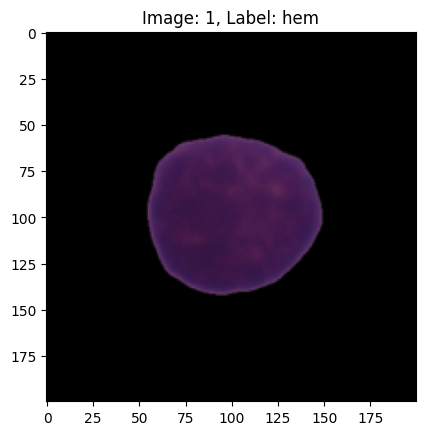

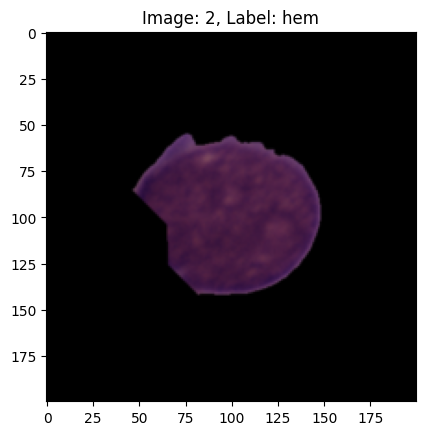

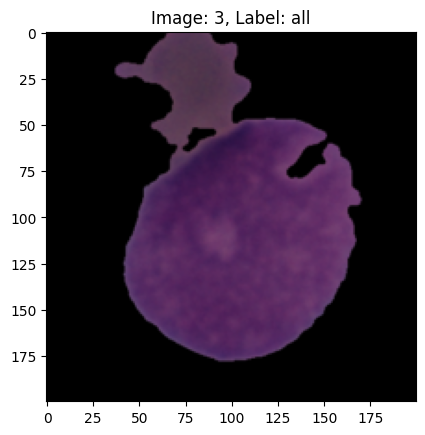

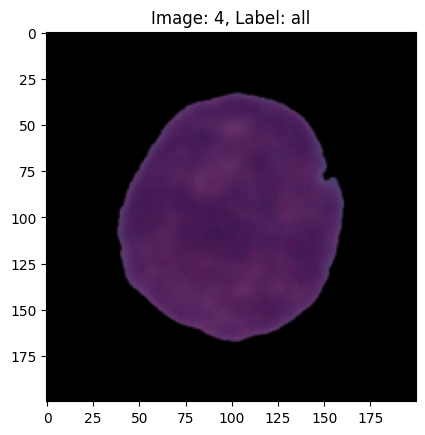

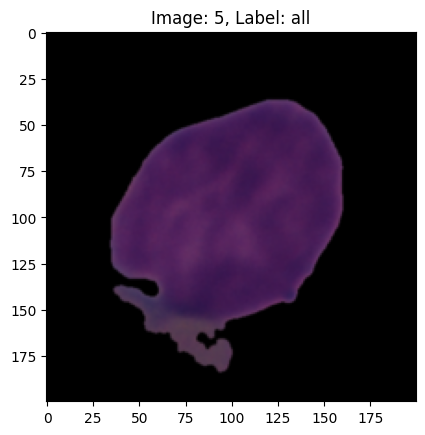

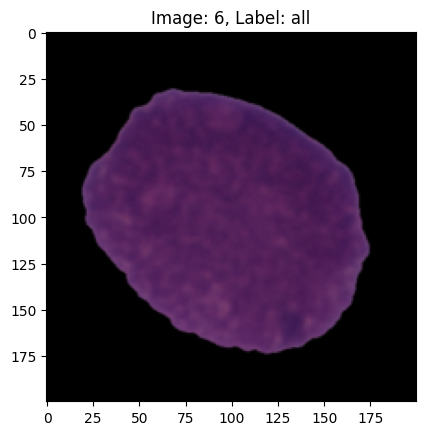

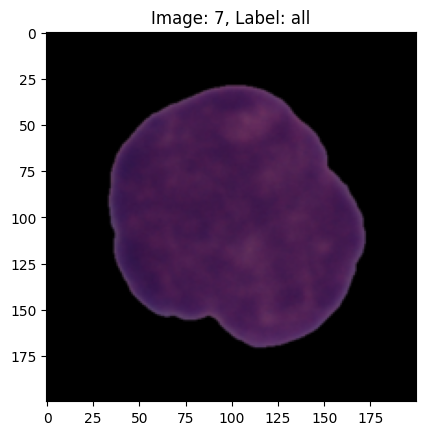

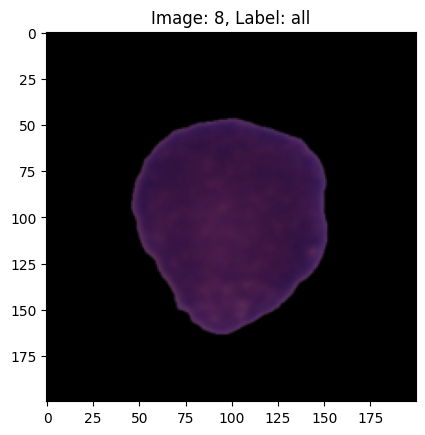

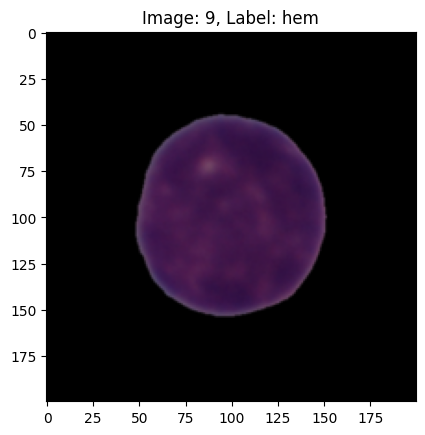

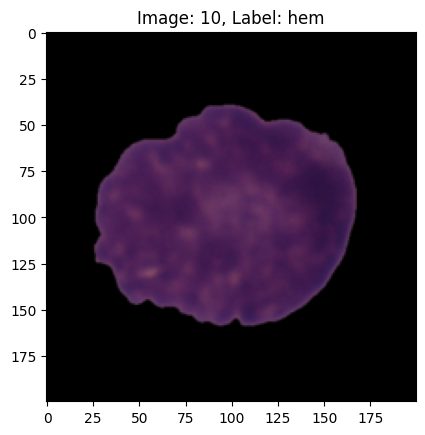

In [122]:
import matplotlib.pyplot as plt

for i in range(10):  # Show 3 images
    img, label = train_data[i]

    # Get the image data (tensor) and convert it back to a NumPy array for manipulation
    img = img.numpy()

    # Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
    img = img.transpose((1, 2, 0))

    # Get the label name from the dataset class labels
    label_name = dataset1.classes[label]

    # Plot the image with a title (including label name)
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

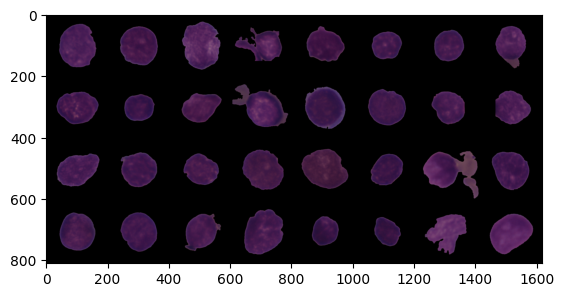

In [123]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

  
batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0) # результатом є тензор

plt.imshow(grid)

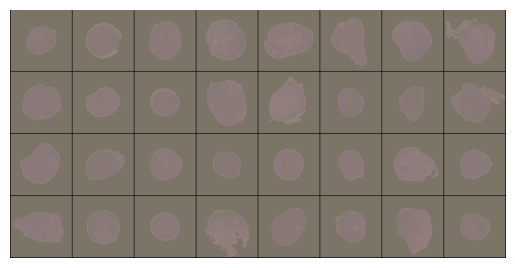

In [124]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Створення завантажувача даних
loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

# Отримуємо перший батч
batch, labels = next(iter(loader))

# Якщо ви застосовували нормалізацію в трансформаціях, використовуйте денормалізацію
denormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Денормалізація (якщо була застосована)
batch = torch.stack([denormalize(img) for img in batch])

# Створюємо сітку
grid = make_grid(batch).permute(1, 2, 0)  # Переміщаємо канали на останнє місце

# Виводимо зображення
plt.imshow(grid)
plt.axis("off")  # Відключаємо осі
plt.show()

In [125]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flat = nn.Flatten()
        
        self.linear = nn.Linear(512, num_classes)

    # def _get_conv_output_size(self, input_size):
    #     with torch.no_grad():
    #         x = torch.zeros(1, *input_size)
    #         x = self.conv1(x)
    #         x = F.relu(x)
    #         x = self.conv2(x)
    #         x = F.relu(x)
    #         x = self.pool(x)
    #         x = self.conv3(x)
    #         x = F.relu(x)
    #         x = self.pool(x)
    #         x = self.conv4(x)
    #         x = F.relu(x)
    #         x = self.pool(x)
    #         x = self.conv5(x)
    #         x = F.relu(x)
    #         x = self.pool(x)
    #         x = self.conv6(x)
    #         x = F.relu(x)
    #         x = self.pool(x)
    #         return x.numel()
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        # print("Shape after conv1:", out.shape)

        out = self.conv2(out)
        out = F.relu(out)
        # print("Shape after conv2:", out.shape)

        out = self.pool1(out)
        # print("Shape after pool1:", out.shape)

        out = self.conv3(out)
        out = F.relu(out)
        # print("Shape after conv3:", out.shape)

        out = self.pool2(out)
        # print("Shape after pool2:", out.shape)

        out = self.conv4(out)
        out = F.relu(out)
        # print("Shape after conv4:", out.shape)

        out = self.pool3(out)
        # print("Shape after pool3:", out.shape)

        out = self.conv5(out)
        out = F.relu(out)
        # print("Shape after conv5:", out.shape)

        out = self.pool4(out)
        # print("Shape after pool4:", out.shape)

        out = self.conv6(out)
        out = F.relu(out)
        # print("Shape after conv6:", out.shape)

        out = self.pool5(out)
        # print("Shape after pool5:", out.shape)

        out = self.flat(out)
        # print("Shape after flatten:", out.shape)

        out = self.linear(out)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = FractureClassifier(num_classes=len(dataset2.classes)).to(device)
model

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
!pip install -q torchsummary

In [ ]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()
    
    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()
        
        # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

In [ ]:
plot_metric(history, 'accuracy_score')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # Переключить модель на ЦП
model.eval()

batch_size = 256
loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

y_test = []
y_pred = []

for X_batch, y_batch in loader:
    batch_pred = model.predict(X_batch)  # Получить предсказания модели
    y_pred.extend(batch_pred.argmax(-1).tolist())  # Применить argmax для получения меток классов
    y_test.extend(y_batch.tolist())  # Добавить истинные метки

# Построить матрицу ошибок
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dataset1.classes)
plt.xticks(rotation=90)
plt.show()